<a href="https://colab.research.google.com/github/wsklee/gym-OpenAI-CartPole/blob/main/OpenAI_Gymnasium_Cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OpenAI Gymnasium Cart Pole
https://gymnasium.farama.org/environments/classic_control/cart_pole/   
As part of CZ3005 Assignment  
By Lee Wonseok

## Installing dependencies:

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

## Importing dependencies and define helper functions

In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

## Loading CartPole environment

In [ ]:
env = gym.make("CartPole-v1")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Solution chosen: Deep Q-Networks (DQN)

Reference: [Playing Atari with Deep Reinforcement Learning](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf), Mnih et al, 2013

The Cart Pole environment requires a model to balance the pole by applying forces in the left and right direction on the cart. The environment involves a continuous state space (cart position, cart velocity, pole angle and pole angular velocity) and discrete actions (0 or 1).

DQN is chosen as it is more suitable for problems with larger state spaces such as the Cart Pole environment

### Characteristic of DQN
DQN combines Q-Learning with deep neural networks. It uses a neural network as a function approximator to estimate the Q-values for state-action pairs, instead of using Q-table

- Q-learning: An agent learns a policy that tells it what action to take under what circumstances. It is model-free and can handle problems with stochastic transitions and rewards.

- Neural network: Used as a function approximator to estimate the Q-values. The input to the network is the state, and the output is the Q-value for each action. The weights of the network are learned during the training process.

- Experience Replay: Past experiences (state, action, reward, next state) are stored in a replay buffer. During training, a batch of experiences is sampled from this buffer to update the network weights. This helps to break the correlation between consecutive experiences, leading to better learning.

- Fixed Q-targets: If we use same parameters (weights) for estimating the Temporal Difference target and the Q-value, there will be a significant correlation between the TD target and the parameters we are changing, which is undesirable. Hence we use a separate network (target) with fixed parameter to estimate the TD target. The parameters of this target network are then updated to the parameters of the online network every few steps.

## DQN Pseudocode

1. **Initialize replay memory** $D$ to capacity $N$

2. **Initialize action-value function** $Q$ with random weights

3. **For each episode** $= 1, M$:
   - Initialize sequence $s_1 = \{x_1\}$
   - **For each time step** $t = 1, T$:
     - With probability $\epsilon$, select a random action $a_t$
     - Otherwise, select $a_t = \max_a Q^*(s_t, a; \theta)$
     - Execute action $a_t$ in the environment and observe reward $r_t$ and state space $x_{t+1}$
     - Set $s_{t+1} = s_t, a_t, x_{t+1}$
     - Store transition $(s_t, a_t, r_t, s_{t+1})$ in $D$
     - Optimize model by
      - Sample random minibatch of transitions $(s_j, a_j, r_j, s_{j+1})$ from $D$
      - Compute the Q-values $Q(s_j, a_j)$ for the current state-action pairs using the policy network.
      - Estimate the next state values $Q(s_{j+1}, a_0)$ for all non-final next states using the target network.
      - Compute the expected Q values for non-terminal states using the Bellman equation.
      - Compute the Huber loss (smooth L1 loss) between the estimated Q-values and the expected Q-values.
      - Perform a gradient descent step to optimize the policy network.
      - Update the policy network's weights using the optimizer.
     - Perform a soft update of the target network's weights. $θ′ ← τ θ + (1 −τ )θ′$


# Task 1: Development of an RL agent

Code reference: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

## Setting up

In [ ]:
from collections import namedtuple, deque
from itertools import count

# set up Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Replay Buffer

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### DQN

In [ ]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

### Constants

In [ ]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
state = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

In [ ]:
steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1

    # With probability ε select a random action a_t
    if sample < eps_threshold:
      return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

    # otherwise select a_t = max_a Q∗(s_t, a; θ)
    else:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)


episode_durations = []

In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    # Sample random minibatch of transitions (s_j, a_j, r_j, s_{j+1}) from D
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Find a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q-values for the current states Q(s_j, a_j)
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Estimate Q-values for the next states Q(s_{j+1}, a_0)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values

    # Compute the expected Q values for non-terminal states
    # using Bellman Equation y_j = r_j + γ * max(Q(s_{j+1}, a_0))
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

## Training

In [ ]:
# Parameter
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 100

In [ ]:
# Run a single episode and return the total reward
def run_episode(env, policy_net, target_net, memory, device):
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    total_reward = 0
    done = False
    while not done:
        action = select_action(state)
        # Execute action a_t in environment and observe reward r_t and state space x_{t+1}
        observation, reward, terminated, truncated = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        total_reward += reward.item()
        done = terminated or truncated

        # Set s_{t+1} = s_t, a_t, x_{t+1}
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition (s_t, a_t, r_t, s_{t+1}) in D
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            break

    # Convert to action from tensor to integer
    action = action.cpu().numpy()[0][0]

    return total_reward, action

In [ ]:
# Train the agent for a specified number of episodes
def train_agent(env, policy_net, target_net, memory, num_episodes, device):
    rewards = []
    for i_episode in range(num_episodes):
        total_reward, action = run_episode(env, policy_net, target_net, memory, device)
        rewards.append(total_reward)
        if (i_episode + 1) % 100 == 0:
            avg_reward = np.mean(rewards[-100:])
            print(f"Episode {i_episode+1}/{num_episodes}, average reward: {avg_reward:.2f}")
    return rewards

In [ ]:
rewards = train_agent(env, policy_net, target_net, memory, num_episodes, device)

Episode 100/600, average reward: 14.38
Episode 200/600, average reward: 88.37
Episode 300/600, average reward: 170.12
Episode 400/600, average reward: 414.02
Episode 500/600, average reward: 437.05
Episode 600/600, average reward: 459.44


In [ ]:
# To save/update the pre-trained model
# Open the left pane in Colab. Select the 'Files' tab.
# Click ‘Refresh’. Right-click the file and choose 'Download'.
torch.save(target_net.state_dict(), 'model_weights.pth')

### Analysis of training result

The cumulative reward increases as the number of training episodes increases. Beyond 300 episodes, the cumulative rewards fluctuates between 350~500, showing that my model is effective

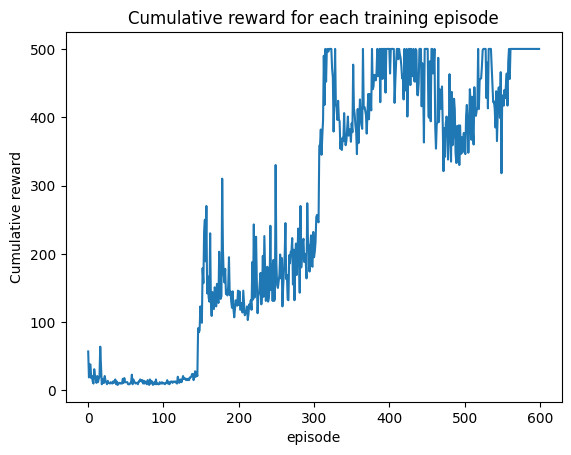

In [ ]:
plt.plot(rewards)
plt.title('Cumulative reward for each training episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

### Demonstrating the correctness of the implementation
For Task 1, we can show the observation and chosen action below:

In [ ]:
# To Load pre-trained model
# from google.colab import files
# uploads = files.upload()

In [ ]:
env = gym.make("CartPole-v1")
state = env.reset()
n_observations = len(state)
n_actions = env.action_space.n
model = DQN(n_observations, n_actions).to(device)
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

DQN(
  (layer1): Linear(in_features=4, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=2, bias=True)
)

In [ ]:
def get_action(state, model):
    with torch.no_grad():
      action_tensor = model(state).max(1).indices.view(1, 1)
      action = action_tensor.cpu().numpy()[0][0]
      return action

In [ ]:
# Demonstrating the correctness of the implementation
observation = env.reset()
observation_tensor = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
action = get_action(observation_tensor, model)
print("Observation: ", observation)
print("Chosen action: ", action)

Observation:  [ 0.04674615 -0.03051531  0.00709059 -0.02856955]
Chosen action:  0


# Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

In [ ]:
# Set parameters
test_num_episodes = 100

In [ ]:
# use the agent developed in Task 1 to play the game for 100 episodes, record the cumulative reward for each round
# plot the reward for each round.

# For task 2. Run a single episode and return the total reward WITHOUT updating the network
def test_run_episode(env, model, device):
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    total_reward = 0
    done = False
    while not done:
        action = get_action(state, model)
        observation, reward, terminated, truncated = env.step(action)
        reward = torch.tensor([reward], device=device)
        total_reward += reward.item()
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Move to the next state
        state = next_state

        if done:
            break

    return total_reward, action

# Test the agent for a specified number of episodes
def test_agent(env, model, test_num_episodes, device):
    rewards = []
    for i_episode in range(test_num_episodes):
        total_reward, action = test_run_episode(env, model, device)
        rewards.append(total_reward)
        if (i_episode + 1) % 10 == 0:
            avg_reward = np.mean(rewards[-100:])
            print(f"Episode {i_episode+1}/{test_num_episodes}, average reward: {avg_reward:.2f}")
    return rewards

In [ ]:
episode_results = test_agent(env, model, test_num_episodes, device)

Episode 10/100, average reward: 500.00
Episode 20/100, average reward: 500.00
Episode 30/100, average reward: 500.00
Episode 40/100, average reward: 500.00
Episode 50/100, average reward: 500.00
Episode 60/100, average reward: 500.00
Episode 70/100, average reward: 500.00
Episode 80/100, average reward: 500.00
Episode 90/100, average reward: 500.00
Episode 100/100, average reward: 500.00


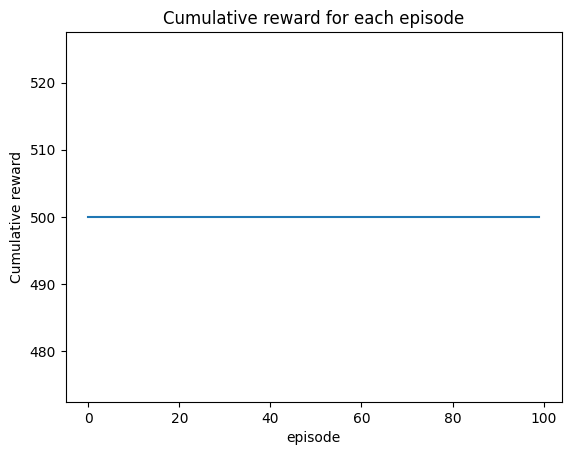

In [ ]:
# DQN plot over 100 episodes
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

Print the average reward over the 100 episodes.

In [ ]:
print("Average cumulative reward:" + str(np.mean(episode_results)))
print("Is my agent good enough? " + str(np.mean(episode_results) > 195))

Average cumulative reward:500.0
Is my agent good enough? True


# Task 3: Render one episode played by the agent

Plug your agent to the code below to obtain rendered result.

In [ ]:
# Using DQN
env = RecordVideo(gym.make("CartPole-v1"), "./video")
state = env.reset()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
done = False
while True:
    env.render()
    action = get_action(state, model)
    observation, reward, terminated, truncated = env.step(action)
    done = terminated or truncated

    if terminated:
        next_state = None
    else:
        next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

    # Move to the next state
    state = next_state

    if done:
        break

env.close()
show_video()

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
